# STROKE PREDICTION WITH DECISION TREE

# 1. Prepare Problem

## 1.1 Setup environment

Run the code block below

In [4]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, OneHotEncoder
import seaborn
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, OneSidedSelection, NeighbourhoodCleaningRule, RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn import tree
from pickle import dump, load

pd.set_option('display.width', 1000)
pd.set_option('precision', 3)
seed = 4
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)


# Box plots
def my_boxplot(data, labels, xlabel, ylabel, title, loc):
    fig = pyplot.figure()
    ax = fig.add_subplot(111)
    pyplot.boxplot(data)
    ax.set_xticklabels(labels)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.title(title)
    pyplot.savefig(loc + '/' + xlabel + ".png")
    pyplot.show()


def my_lineplot(x, y1, y2, label1, label2, xlabel, ylabel, title, loc):
    line1 = pyplot.plot(x, y1, '-o', label=label1)
    line2 = pyplot.plot(x, y2, '-o', label=label2)
    pyplot.legend()
    pyplot.ylabel(ylabel)
    pyplot.xlabel(xlabel)
    pyplot.savefig(loc + '/' + title + ".png")
    pyplot.show()

def visulize_boundary(model, X, Y, pos):
    model.fit(X[['age', 'avg_glucose_level']], Y)

    min1, max1 = X['age'].min() - 5, X['age'].max() + 5
    min2, max2 = X['avg_glucose_level'].min() - 5, X['avg_glucose_level'].max() + 5
    x1grid = np.arange(min1, max1, 1)
    y1grid = np.arange(min2, max2, 1)
    xx, yy = np.meshgrid(x1grid, y1grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1, r2))
    yhat = model.predict_proba(grid)
    yhat = yhat[:xx.shape[0]*xx.shape[1], 0]
    zz = yhat.reshape(xx.shape)
    cm = 'RdBu'
    pyplot.subplot(*pos)
    c = pyplot.contourf(xx, yy, zz, cmap=cm, alpha=0.2, levels=9)
    pyplot.colorbar(c)
    seaborn.scatterplot(data=data_test, x='age', y='avg_glucose_level', hue='true', s=20)

## 1.2 Load dataset

Run the code block below

In [5]:
filename = "healthcare-dataset-stroke-data.csv"
data = pd.read_csv(filename, index_col="id")
features = ['age', 'avg_glucose_level', 'bmi', 'smoking_status', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']   #
target = 'stroke'

### Distinguish Numerical and Categorical Features

Downhere, we'll mark columns which have number of unique values less than 1% of total number of observations as categorical.

Run the code block below

In [6]:
# Remove outlier associated with `age` (only 1 outlier)
data = data[data['gender'] != "Other"]

# determine by percentage of unique values
categorical_ix = []
numerical_ix = []
n_uniques = data.nunique()
for col in features:
    percentage = n_uniques[col]/data.shape[0] * 100
    if percentage < 1:
        categorical_ix.append(col)
    else:
        numerical_ix.append(col)
print("Categorical:", categorical_ix)
print("Numerical:", numerical_ix)

# 3. Prepare Data

Categorical: ['smoking_status', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']
Numerical: ['age', 'avg_glucose_level', 'bmi']


## 3.1) Data Cleaning

### Check label noise
Run the code block below

In [5]:
dups = data[features].duplicated()
data[dups].shape

(0, 11)

Luckily, there's no sign of label noise.

### Look for outliers on numerical features

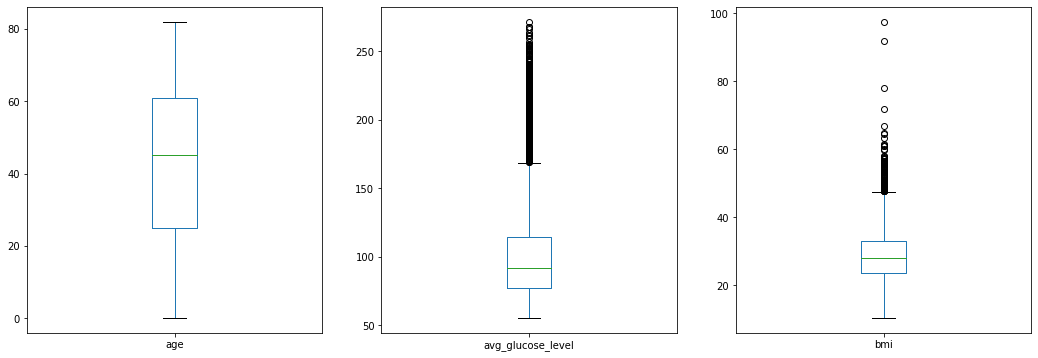

age  avg_glucose_level       bmi
count  5109.000           5109.000  4908.000
mean     43.230            106.140    28.895
std      22.614             45.285     7.854
min       0.080             55.120    10.300
25%      25.000             77.240    23.500
50%      45.000             91.880    28.100
75%      61.000            114.090    33.100
max      82.000            271.740    97.600

In [6]:
data[numerical_ix].plot(kind='box', subplots=True, layout=(1, 3), figsize=(18, 6))
pyplot.show()

data[numerical_ix].describe()

By looking at the table, box plot and by research domain specific knowledge, we infer:

* *age* feature has outliers, where min value should be greater than or equal to 1
* *bmi* feature has outliers, where max value should not be far greater than 70

#### Outlier Detection By Quantile Range

Factor 4 of IQR from quantile 75th seems to be a reasonable boundary with *bmi* values.

If you want to use this method, run the code block below


In [7]:
outlier_strategy = 'Quantile_Range_Outlier_Detection'
q25, q75 = data['bmi'].quantile(0.25), data['bmi'].quantile(0.75)
iqr = q75 - q25
factor = 4
cut_off = iqr * factor
bmi_upper = q75 + cut_off
age_lower = 1

#### Detect and view outliers

Run the code block below

Quantile_Range_Outlier_Detection
UPPER BOUND FOR BMI IS NOW: 71.5
LOWER BOUND FOR AGE IS NOW: 1
> NUMBER OF OUTLIERS DETECTED: 47


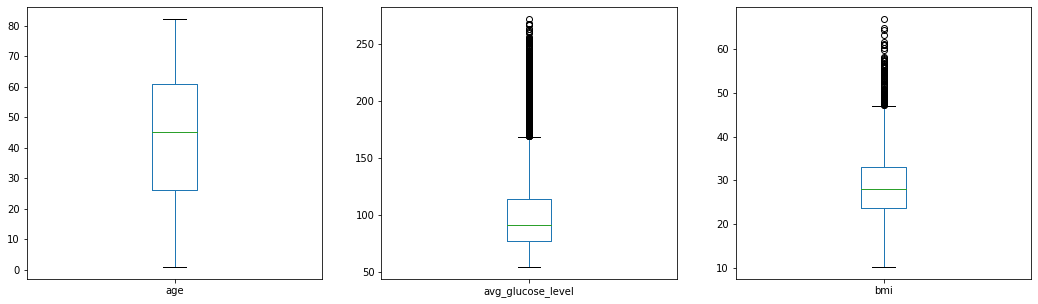

> THESE ARE OUTLIERS:


gender    age  hypertension  heart_disease ever_married work_type Residence_type  avg_glucose_level   bmi smoking_status  stroke
id                                                                                                                                     
7559   Female   0.64             0              0           No  children          Urban              83.82  24.9        Unknown       0
22706  Female   0.88             0              0           No  children          Rural              88.11  15.5        Unknown       0
545      Male  42.00             0              0          Yes   Private          Rural             210.48  71.9   never smoked       0
61511  Female   0.32             0              0           No  children          Rural              73.71  16.2        Unknown       0
41097  Female  23.00             1              0           No   Private          Urban              70.03  78.0         smokes       0
54747    Male   0.88             0              0           No  children          Rural             157.57  19.2        Unknown       0
53279    Male   0.24             0              0           No  children          Rural             118.87  16.3        Unknown       0
66772  Female   0.32             0              0           No  children          Rural              55.86  16.0        Unknown       0
68908  Female   0.72             0              0           No  children          Urban              66.36  23.0        Unknown       0
30084    Male   0.80             0              0           No  children          Rural              98.67  17.5        Unknown       0
40544    Male   0.40             0              0           No  children          Urban             109.56  14.3        Unknown       0
47350  Female   0.08             0              0           No  children          Urban             139.67  14.1        Unknown       0
53126  Female   0.64             0              0           No  children          Urban              62.27  17.3        Unknown       0
6596     Male   0.56             0              0           No  children          Rural             111.77  21.1        Unknown       0
42500    Male   0.24             0              0           No  children          Rural             146.97  18.5        Unknown       0
67099    Male   0.56             0              0           No  children          Rural              57.02  20.7        Unknown       0
34261    Male   0.64             0              0           No  children          Rural              86.74  16.2        Unknown       0
38920    Male   0.48             0              0           No  children          Urban              73.02   NaN        Unknown       0
56420    Male  17.00             1              0           No   Private          Rural              61.67  97.6        Unknown       0
1275     Male   0.88             0              0           No  children          Urban             112.19  18.9        Unknown       0
20257    Male   0.88             0              0           No  children          Urban              90.62  22.4        Unknown       0
48406    Male   0.88             0              0           No  children          Urban              85.38  23.4        Unknown       0
68382    Male   0.32             0              0           No  children          Urban             127.78  20.8        Unknown       0
61836  Female   0.80             0              0           No  children          Urban             106.59  15.5        Unknown       0
760      Male   0.80             0              0           No  children          Urban              75.22  33.1        Unknown       0
42938    Male   0.64             0              0           No  children          Urban              60.40  17.3        Unknown       0
64974    Male   0.24             0              0           No  children          Urban              58.35  18.6        Unknown       0
14877    Male   0.56             0              0           No 

In [8]:
print(outlier_strategy)
print("UPPER BOUND FOR BMI IS NOW:", bmi_upper)
print("LOWER BOUND FOR AGE IS NOW:", age_lower)

# identify non-outlier indexes
mask_outlier = (data["bmi"] > bmi_upper) | (data["age"] < age_lower)
mask_nonoutlier = mask_outlier == False

print("> NUMBER OF OUTLIERS DETECTED:", data[mask_outlier].shape[0])

# box and whisker plot
data[mask_nonoutlier][numerical_ix].plot(kind='box', subplots=True, layout=(1,3), figsize=(18, 5))
pyplot.savefig('./exploration_figures/boxplot_after.png')
pyplot.show()

print("> THESE ARE OUTLIERS:")
data[mask_outlier]

#### Remove Detected Outliers On The Entire Data Set

Run the code block below

In [9]:
data = data[mask_nonoutlier].copy()

### Count number of missing values

In [10]:
for col in data.columns:
    n_miss = data[col].isnull().sum()
    perc = n_miss/data.shape[0] * 100
    print("> {:<20}{:>10}{:>15.1f}%".format(col, n_miss, perc))

> gender                       0            0.0%
> age                          0            0.0%
> hypertension                 0            0.0%
> heart_disease                0            0.0%
> ever_married                 0            0.0%
> work_type                    0            0.0%
> Residence_type               0            0.0%
> avg_glucose_level            0            0.0%
> bmi                        200            4.0%
> smoking_status               0            0.0%
> stroke                       0            0.0%


Looking at the above table and unique values of each column, we could tell *bmi* has 201 missing values.


Later on, we'll use `SimpleImputer` in Scikit-learn to replace missing values in *bmi* with its mean


## b) Data Transforms

Downhere, we'll select strategy for data transformation

#### With Numerical Features

* Option: Discretize. This can be done by using `KBinsDiscretizer` from Scikit-learn. We'll test its impact on Decision Tree performance.
> As far as we know, *age* and *bmi* can be separated into 4 groups each:
>* *age*:
>>* Under 14: Children
>>* 15-24: Youth
>>* 25-64: Adults
>>* 65 and over: Senior
>* *bmi*:
>>* Below 18.5: Underweight
>>* 18.5 – 24.9:	Norma
>>* 25.0 – 29.9:	Overweight
>>* 30.0 and Above: Obese
>
> In addition, blood sugar levels can also be split into 4 group, though normal sugar level depends on each specific age group:
>>* Fasting
>>* Before meal
>>* 1-2 hours after eating
>?* Bedtime

#### Encode Categorial Features

* Option 1: Convert to ordinal data
* Option 2: Convert to nominal data

From the name and unique values of each categorical feature listed above, it's intuitive to label all of them as nominal, but we'll try treating them as ordinal for some kind of experiments later on.


# 4. Evaluate Algorithms

## 4.1 Split-out Train Set And Test Set

Run the code block below

In [10]:
test_size = 0.33
X_train, X_test, Y_train, Y_test = train_test_split(data[features], data['stroke'], test_size=test_size, stratify=data['stroke'], random_state=seed)

## 4.2 Test options and evaluation metric

We will use repeated stratified 5-fold cross validation to estimate F1 score.

Run the code block below

In [11]:
scoring = 'f1'
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=seed)

## 4.3 Spot-check sampling techniques

For standalone sampling, we select: Random oversampling, SMOTE, SVM SMOTE, Borderline SMOTE, Random undersampling, One-sided selection, Neighbourhood Cleaning Rule

For combination of sampling, we select: SMOTE Tomek and SMOTE ENN.


Note that:
* with One-side Selection and Neighbourhood Cleaning Rule: we test only one and duplicate the result to draw a line graph.
* with other: we test different ratios.

Run the code block below

No sampling: 0.153858
ROS (ratio:0.1): 0.157742
ROS (ratio:0.2): 0.149544
ROS (ratio:0.3): 0.142456
ROS (ratio:0.4): 0.128911
ROS (ratio:0.5): 0.129102
ROS (ratio:0.6): 0.124952
ROS (ratio:0.7): 0.113594
ROS (ratio:0.8): 0.129463
ROS (ratio:0.9): 0.126258
No sampling: 0.153858
SMOTE (ratio:0.1): 0.146149
SMOTE (ratio:0.2): 0.148099
SMOTE (ratio:0.3): 0.151595
SMOTE (ratio:0.4): 0.151562
SMOTE (ratio:0.5): 0.144889
SMOTE (ratio:0.6): 0.147957
SMOTE (ratio:0.7): 0.155269
SMOTE (ratio:0.8): 0.141302
SMOTE (ratio:0.9): 0.135237
No sampling: 0.153858
SVMSMOTE (ratio:0.1): 0.153029
SVMSMOTE (ratio:0.2): 0.154895
SVMSMOTE (ratio:0.3): 0.150588
SVMSMOTE (ratio:0.4): 0.139615
SVMSMOTE (ratio:0.5): 0.149228
SVMSMOTE (ratio:0.6): 0.135940
SVMSMOTE (ratio:0.7): 0.149099
SVMSMOTE (ratio:0.8): 0.142241
SVMSMOTE (ratio:0.9): 0.141361
No sampling: 0.153858
BLSMOTE (ratio:0.1): 0.158409
BLSMOTE (ratio:0.2): 0.155783
BLSMOTE (ratio:0.3): 0.147141
BLSMOTE (ratio:0.4): 0.135955
BLSMOTE (ratio:0.5): 0.1357

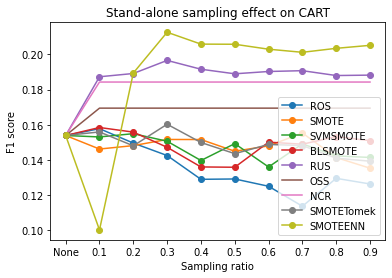

In [35]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

ratios = np.arange(0.1, 1, 0.1)
names = ['None'] + [str(round(ratio, 1)) for ratio in ratios]

naive_model = Pipeline([step_trans,
                  step_cart])

models = [
    Pipeline([step_trans,
                      ('ROS', RandomOverSampler(random_state=seed)),
                      step_cart]),
          Pipeline([step_trans,
                      ('SMOTE', SMOTE(random_state=seed)),
                      step_cart]),
          Pipeline([step_trans,
                      ('SVMSMOTE', SVMSMOTE(random_state=seed)),
                      step_cart]),
          Pipeline([step_trans,
                      ('BLSMOTE', BorderlineSMOTE(random_state=seed)),
                      step_cart]),
    Pipeline([step_trans,
                      ('RUS', RandomUnderSampler(random_state=seed)),
                      step_cart]),
          Pipeline([step_trans,
                      ('OSS', OneSidedSelection(random_state=seed)),
                      step_cart]),
          Pipeline([step_trans,
                      ('NCR', NeighbourhoodCleaningRule()),
                      step_cart]),
    Pipeline([step_trans,
                  ('SMOTETomek', SMOTETomek(random_state=seed)),
                  step_cart]),
          Pipeline([step_trans,
                  ('SMOTEENN', SMOTEENN(random_state=seed)),
                  step_cart])
          ]

for model in models:

    cv_results = cross_val_score(naive_model, X_train, Y_train, cv=kfold, scoring=scoring)
    results = [cv_results.mean()]
    print("No sampling: %f" % (cv_results.mean()))

    if model.steps[1][0] != 'OSS' and model.steps[1][0] != 'NCR':
        for ratio in ratios:
            model.steps[1][1].set_params(sampling_strategy=ratio)
            cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
            results.append(cv_results.mean())
            print("%s (ratio:%.1f): %f" % (model.steps[1][0], ratio, cv_results.mean()))
        line = pyplot.plot(names, results, '-o', label=model.steps[1][0])
    else:
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.extend([cv_results.mean()] * (len(ratios)))
        print("%s: %f" % (model.steps[1][0], cv_results.mean()))
        line = pyplot.plot(names, results, '-', label=model.steps[1][0])

    # line = pyplot.plot(names, results, '-o', label=model.steps[1][0])
    pyplot.legend()
    pyplot.ylabel('F1 score')
    pyplot.xlabel('Sampling ratio')

pyplot.title("Spot-check sampling effect on CART")
pyplot.savefig('./CART_figures/CART_spotcheck_sampling.png')
pyplot.show()


After several runs, we notice that SMOTEENN is the most promising. In the next part of notebook, we'll use SMOTE ENN with ratio 0.3 as default sampling technique

## 4.7 Class-weighed Decision Tree

After consulting in several article, we feel tempted to test trying cost-sensitive decision tree. Though this is a large subfield of machine learning. In our project, we carry out this by tuning `class_weight` in Scikit-learn `DecisionTreeClassifier`.

Run the code block below

Class_weight 10: 0.125639
Class_weight 15: 0.139626
Class_weight 20: 0.135886
Class_weight 25: 0.132160
Class_weight 30: 0.121637
Class_weight 35: 0.125644


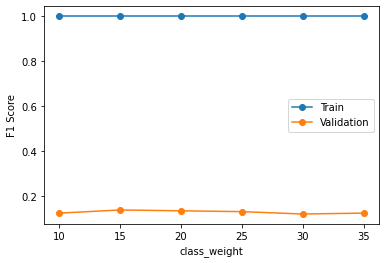

In [20]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                     step_cart])
train_results = []
validation_results = []
ratios = [k for k in range(10, 40, 5)]
class_weights = [{0: 1, 1: k} for k in ratios]

for class_weight in class_weights:
    model['CART'].set_params(class_weight=class_weight)
    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())
    print("Class_weight %d: %f" % (class_weight[1], cv_results['test_score'].mean()))

my_lineplot(x=ratios, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='class_weight', ylabel='F1 Score', title='CART_class_weight', loc='./CART_figures')

Contrary to our expectation, there's no improvement. I'm so confused, can you explain for me?

## 4.8 Different encoding strategies' effect on CART model's performance

In our project, there's not ordinal variable. We'll test which kind of encoding is better for our specific problem.

Run the code block below

Ordinal: 0.212643
... with: n_leaves: 160 	depth: 16
OneHot: 0.214212
... with: n_leaves: 169 	depth: 16


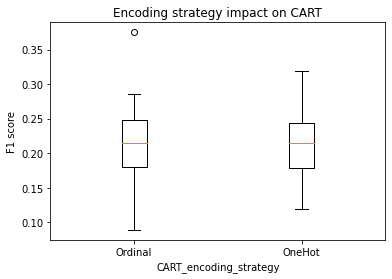

In [36]:
transformers = [('Ordinal', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                               ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                              remainder='passthrough')),
                ('OneHot', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                              ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                             remainder='passthrough'))
                ]

step_smote = ('SMOTEENN', SMOTEENN(sampling_strategy=0.3, random_state=seed))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

results = []
names = []
models = []

for name, transformer in transformers:
    model = Pipeline([('Trans', transformer),
                      step_smote,
                      step_cart])
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    print("%s: %f" % (name, cv_results.mean()))

    model.fit(X_train, Y_train)
    models.append(model)

    print("... with: n_leaves: %d \tdepth: %d" % (model['CART'].get_n_leaves(), model['CART'].get_depth()))

my_boxplot(xlabel='CART_encoding_strategy', data=results, labels=names, ylabel="F1 score", title="Encoding strategy impact on CART", loc='./CART_figures')

According to some articles, Onehot encoding is generally more suitable for norminal variables and in Decision Tree model, Ordinal encoding is more suitable.

In our problem, after doing many experiment, we do not any significant different.

## 4.9) Discretization's effect on CART's performance

Decision Tree prefers categorical variables. So, it's desirable to transform numerical variables to have discrete probability distribution where each value is assigned a label and have an ordinal relationship

Run the code block below

NoDiscretizer: 0.214212
... with: n_leaves: 169 	depth: 16
2Bins: 0.129539
... with: n_leaves: 133 	depth: 16
3Bins: 0.182693
... with: n_leaves: 161 	depth: 13
4Bins: 0.143885
... with: n_leaves: 178 	depth: 14


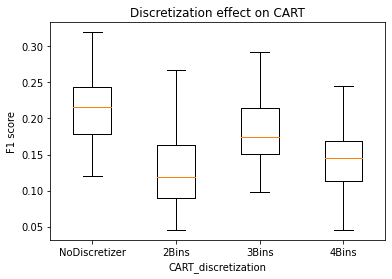

In [37]:
transformers = [('NoDiscretizer', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                                               ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                                              remainder='passthrough')),
                ('2Bins', ColumnTransformer([('NumTrans', Pipeline([('SimpleImputer', SimpleImputer()), ('KBinsDiscretizer', KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans'))]), numerical_ix),
                                                        ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                                       remainder='passthrough')),
                ('3Bins', ColumnTransformer([('NumTrans', Pipeline([('SimpleImputer', SimpleImputer()), ('KBinsDiscretizer', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans'))]), numerical_ix),
                                                        ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                                       remainder='passthrough')),
                ('4Bins', ColumnTransformer([('NumTrans', Pipeline([('SimpleImputer', SimpleImputer()), ('KBinsDiscretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans'))]), numerical_ix),
                                                        ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                                       remainder='passthrough'))
                ]

step_smote = ('SMOTEENN', SMOTEENN(sampling_strategy=0.3, random_state=seed))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

results = []
names = []
for name, transformer in transformers:
    model = Pipeline([('Trans', transformer),
                      step_smote,
                      step_cart])
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    print("%s: %f" % (name, cv_results.mean()))

    model.fit(X_train, Y_train)

    print("... with: n_leaves: %d \tdepth: %d" % (model['CART'].get_n_leaves(), model['CART'].get_depth()))

my_boxplot(xlabel='CART_discretization', data=results, labels=names, ylabel="F1 score", title="Discretization effect on CART", loc='./CART_figures')

Discretization seems to degrade the performance of the model. Why? I don't know, do you know? :)

## 4.10 Algorithm Tuning

```
DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
```

In [40]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(sampling_strategy=0.3, random_state=seed))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

#### `splitter`

According to some articles, decision trees tend to overfit on data with large number of features.

Besides, it can do feature selection automatically by applying (Im)purity measure. This can be done by set parameter `splitter=best`. Another value for `splitter` is `random`. If we have hundreds of features, `best` is more preferred because `random` might result in features that don’t give much information, which would lead to a more deeper, less precise tree.

However, with our Stroke data is small with 10 features, so we might be able to see the difference.

Run the code block below

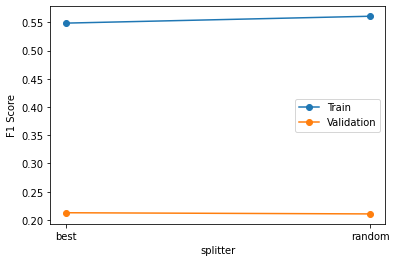

In [41]:
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

train_results = []
validation_results = []
splitters = ['best', 'random']

for splitter in splitters:
    model['CART'].set_params(splitter=splitter)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=splitters, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='splitter', ylabel='F1 Score', title='CART_tune_splitter', loc='./CART_figures')

#### `max_depth`

This indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data. However, `max_depth` needs controlling to prevent overfitting.

Run the code block below

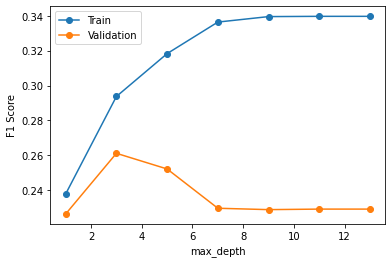

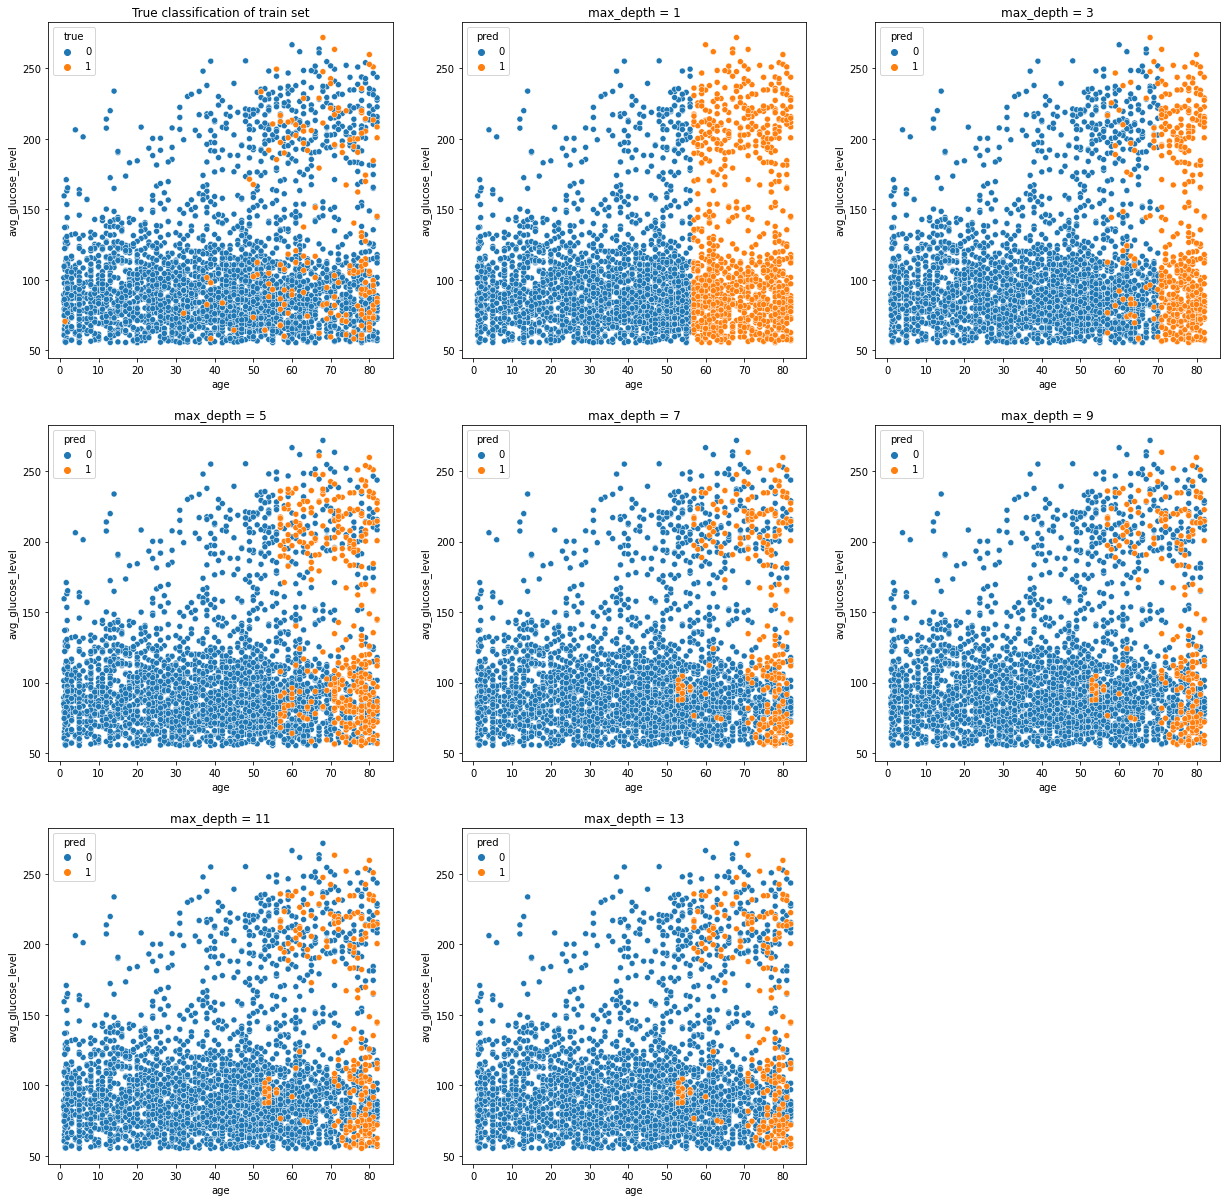

In [108]:
step_cart = ('CART', DecisionTreeClassifier(random_state=seed, min_samples_split=37, min_samples_leaf=11))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

train_results = []
validation_results = []
max_depths = np.arange(1, 15, 2)

for max_depth in max_depths:
    model['CART'].set_params(max_depth=max_depth)
    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=max_depths, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='max_depth', ylabel='F1 Score', title='CART_tune_maxdepth', loc='./CART_figures')



data_train = X_train.copy()
data_train['true'] = Y_train
data_train.sort_values('true', inplace=True)

pyplot.figure(figsize=(21, 21))
pyplot.subplot(3, 3, 1)
seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='true')
pyplot.title('True classification of train set')

i = 2
for max_depth in max_depths:
    model['CART'].set_params(max_depth=max_depth)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_train)

    data_train = X_train.copy()

    data_train['pred'] = Y_pred
    data_train.sort_values('pred', inplace=True)
    pyplot.subplot(3, 3, i)
    seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='pred')
    pyplot.title('max_depth = ' + str(max_depth))
    i += 1

pyplot.savefig('./CART_figures/CART_maxdepth.png')
pyplot.show()

As we can see in the figure, the model predicts fairly well on train set as `max_depth` increases, but fails on new data.


#### `min_samples_split`

The minimum number of samples required to split an internal node. When we increase `min_samples_split`, tree becomes more constrained because it have to consider more examples.

Run the code block below

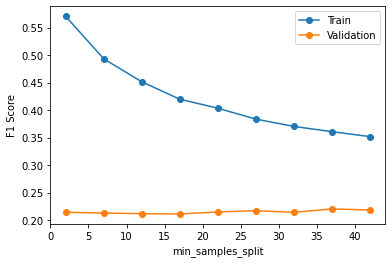

In [55]:
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

train_results = []
validation_results = []
min_samples_splits = np.arange(2, 43, 5)

for min_samples_split in min_samples_splits:
    model['CART'].set_params(min_samples_split=min_samples_split)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=min_samples_splits, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='min_samples_split', ylabel='F1 Score', title='CART_tune_minsamplessplit', loc='./CART_figures')

#### `min_samples_leaf`

The minimum number of samples required to be at a leaf node. At any depth, regardless of `min_samples_split`, a split point is only be accepted if each of its leaves have at least `min_samples_leaf` samples.

Run the code block below

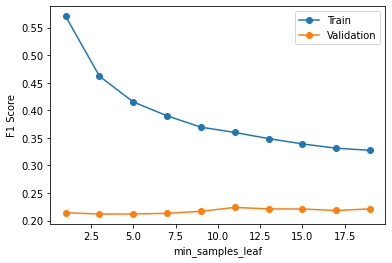

In [56]:
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

train_results = []
validation_results = []
min_samples_leafs = np.arange(1, 21, 2)

for min_samples_leaf in min_samples_leafs:
    model['CART'].set_params(min_samples_leaf=min_samples_leaf)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=min_samples_leafs, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='min_samples_leaf', ylabel='F1 Score', title='CART_tune_minleafsplit', loc='./CART_figures')

Grid search to find best combination of `min_samples_split` and `min_samples_leaf`

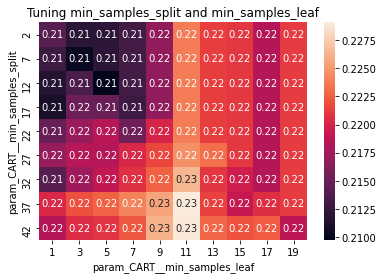

In [74]:
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

splits = np.arange(2, 43, 5)
leafs = np.arange(1, 21, 2)

param_grid = dict(CART__min_samples_split=splits, CART__min_samples_leaf=leafs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid.fit(X_train, Y_train)

pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_), values='mean_test_score', index='param_CART__min_samples_split', columns='param_CART__min_samples_leaf')
seaborn.heatmap(pvt, annot=True)
pyplot.title("Tuning min_samples_split and min_samples_leaf")
pyplot.savefig("./CART_figures/CART_gridsearch.png")
pyplot.show()

View how the combination affect prediction results.

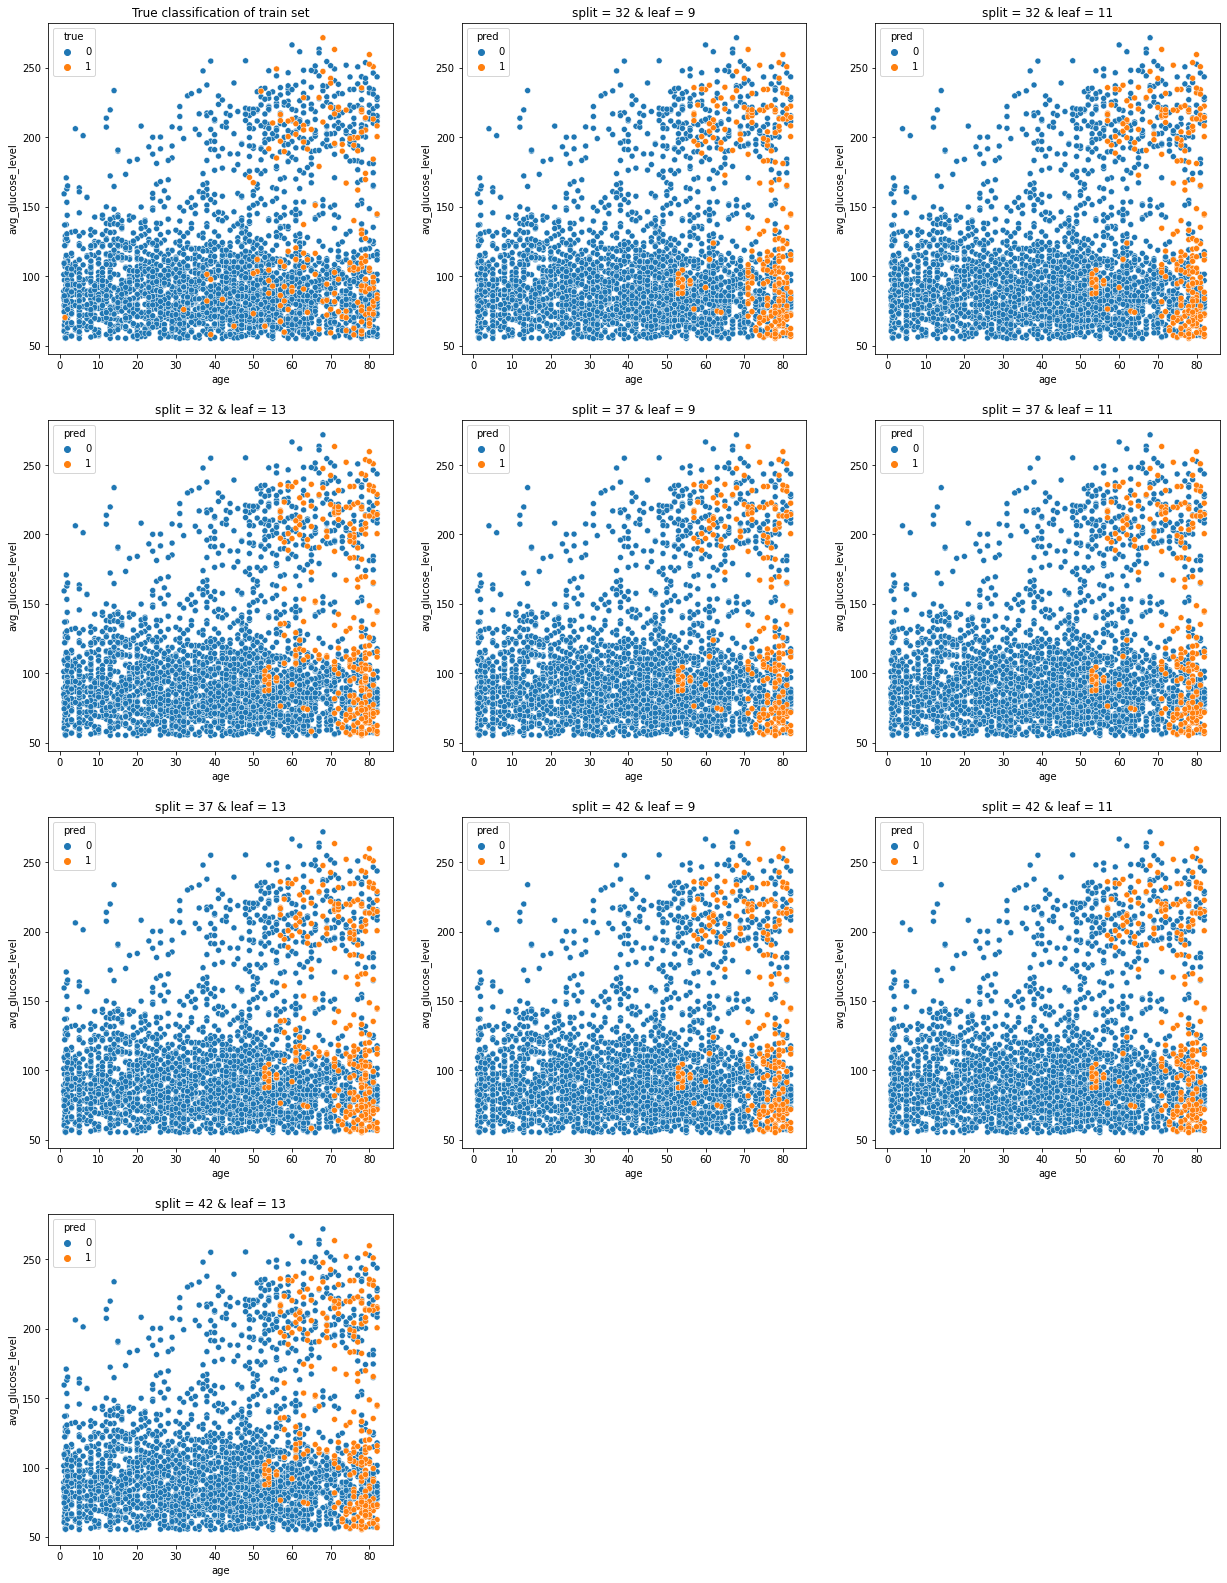

In [81]:
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

min_samples_splits = [32, 37, 42]
min_samples_leafs = [9, 11, 13]

data_train = X_train.copy()
data_train['true'] = Y_train
data_train.sort_values('true', inplace=True)

pyplot.figure(figsize=(21, 28))
pyplot.subplot(4, 3, 1)
seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='true')
pyplot.title('True classification of train set')

i = 2
for min_samples_split in min_samples_splits:
    for min_samples_leaf in min_samples_leafs:
        model['CART'].set_params(min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_train)

        data_train = X_train.copy()

        data_train['pred'] = Y_pred
        data_train.sort_values('pred', inplace=True)
        pyplot.subplot(4, 3, i)
        seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='pred')
        pyplot.title('split = %d & leaf = %d' % (min_samples_split, min_samples_leaf))
        i += 1

pyplot.savefig("./CART_figures/CART_split_leaf.png")
pyplot.show()


#### `max_features`

It represents the maximum number of features to consider when looking for the best split.

Run the code block below

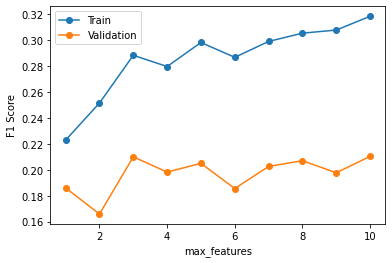

In [82]:
step_cart = ('CART', DecisionTreeClassifier(random_state=seed, min_samples_split=37, min_samples_leaf=11))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

train_results = []
validation_results = []
max_featuress = np.arange(1, 11, 1)

for max_features in max_featuress:
    model['CART'].set_params(max_features=max_features)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=max_featuress, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='max_features', ylabel='F1 Score', title='CART_tune_maxfeatures', loc='./CART_figures')

#### `ccp_alpha`

All the tuning steps done above is refered to as pre-pruning. In this part we'll do post-pruning by controlling the cost complexity pruning.

Let's view the appropriate values for `ccp_alpha` for tuning.

Run the code block below

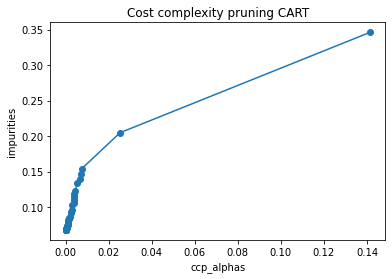

In [83]:
pipeline = Pipeline([step_trans,
                     step_smote
                    ])
cart = DecisionTreeClassifier(random_state=seed, min_samples_split=37, min_samples_leaf=11)

X_new, Y_new = pipeline.fit_resample(X_train, Y_train)

path = cart.cost_complexity_pruning_path(X_new, Y_new)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

line = pyplot.plot(ccp_alphas, impurities, '-o')
pyplot.ylabel('impurities')
pyplot.xlabel('ccp_alphas')

pyplot.title("Cost complexity pruning CART")
pyplot.savefig('./CART_figures/CART_cost_complexity_pruning.png')
pyplot.show()

Now, we'll tune this parameter.

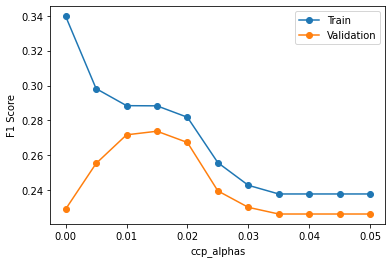

In [84]:
step_cart = ('CART', DecisionTreeClassifier(random_state=seed, min_samples_split=37, min_samples_leaf=11))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

train_results = []
validation_results = []
ccp_alphas = np.arange(0, 0.051, 0.005)

for ccp_alpha in ccp_alphas:
    model['CART'].set_params(ccp_alpha=ccp_alpha)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=ccp_alphas, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='ccp_alphas', ylabel='F1 Score', title='CART_tune_ccpalpha', loc='./CART_figures')

Looking at the figure above, we're something to happy about the lift in the evaluation of the validation set with `ccp_alpha` <= 0.03

However, I'm so lucky to do another crazy experiment below.

Pleaseeee run the code block below

ccp_alpha (0.001): 0.314214
ccp_alpha (0.002): 0.319018
ccp_alpha (0.003): 0.315113
ccp_alpha (0.004): 0.292845
ccp_alpha (0.005): 0.292845
ccp_alpha (0.006): 0.292845
ccp_alpha (0.007): 0.290954
ccp_alpha (0.008): 0.291725


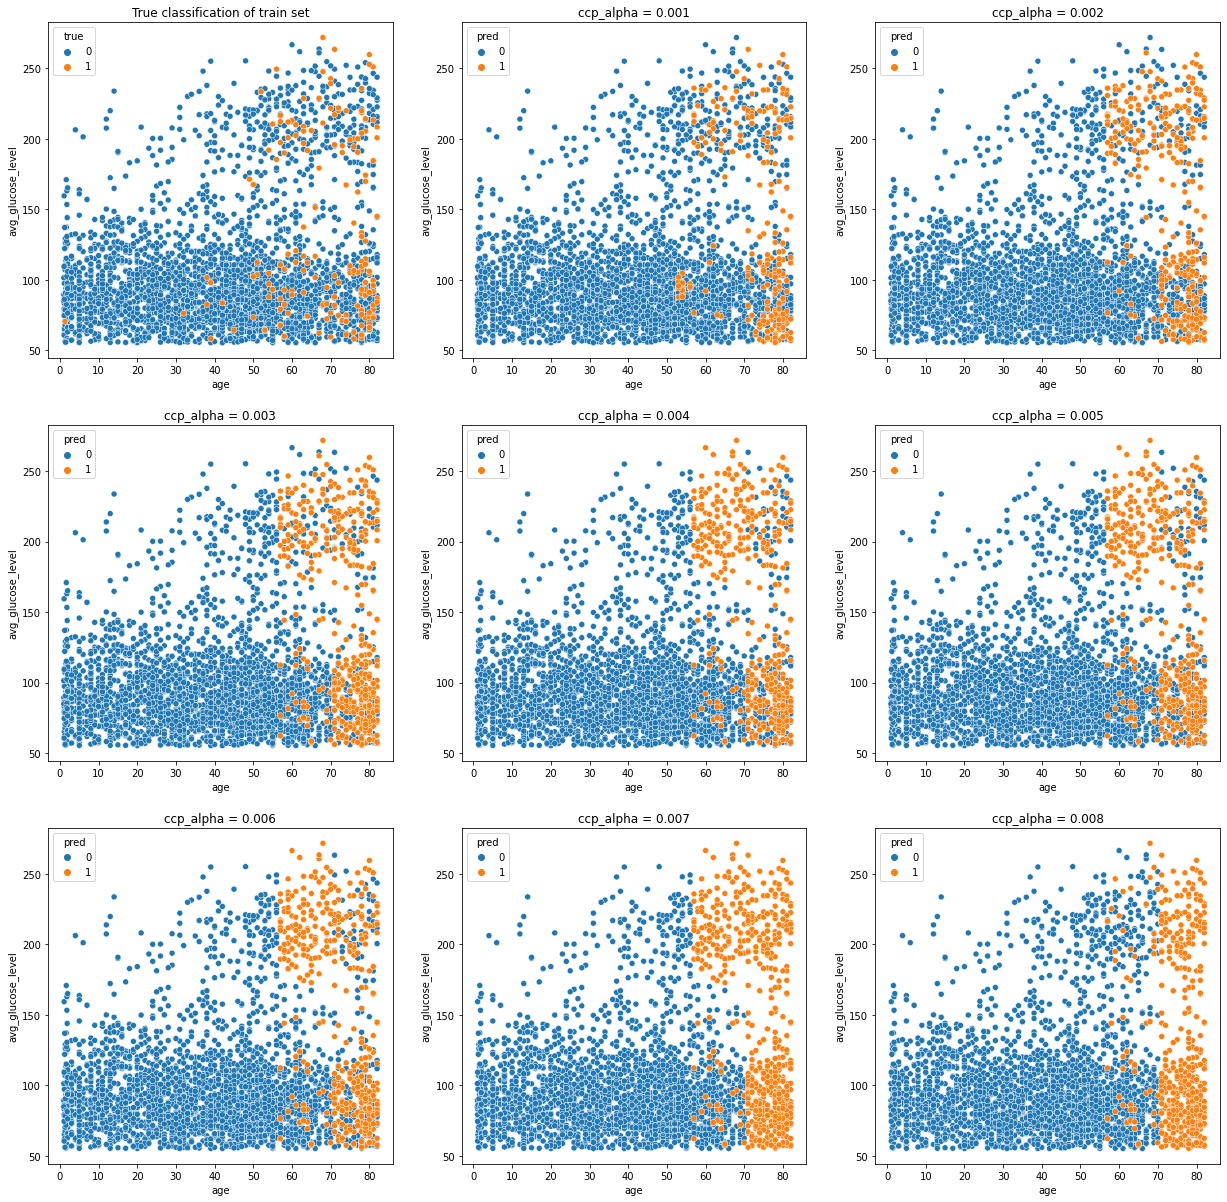

In [85]:
step_cart = ('CART', DecisionTreeClassifier(random_state=seed, min_samples_split=37, min_samples_leaf=11))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

ccp_alphas = np.arange(0.001, 0.009, 0.001)

data_train = X_train.copy()
data_train['true'] = Y_train
data_train.sort_values('true', inplace=True)

pyplot.figure(figsize=(21, 21))
pyplot.subplot(3, 3, 1)
seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='true')
pyplot.title('True classification of train set')

i = 2
for ccp_alpha in ccp_alphas:
    model['CART'].set_params(ccp_alpha=ccp_alpha)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_train)
    print("ccp_alpha (%.3f): %f" % (ccp_alpha, f1_score(Y_train, Y_pred)))

    data_train = X_train.copy()

    data_train['pred'] = Y_pred
    data_train.sort_values('pred', inplace=True)
    pyplot.subplot(3, 3, i)
    seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='pred')
    pyplot.title('ccp_alpha = ' + str(ccp_alpha))
    i += 1

pyplot.savefig('./CART_figures/CART_ccpalpha.png')
pyplot.show()

Though the performance lifts significantly, the figure above suggests a cautious if we rely on the model. Almost all instances in the right hand is misclassified, which is probably not real.

# 6. Finalizing

## 6.1 Predictions on test set

Base on these above experiments, we'll finalize our CART model as below.


CART training time: 2.552304744720459s
CART predicting time: 0.049285173416137695s
[[1487  102]
 [  57   25]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1589
           1       0.20      0.30      0.24        82

    accuracy                           0.90      1671
   macro avg       0.58      0.62      0.59      1671
weighted avg       0.93      0.90      0.91      1671



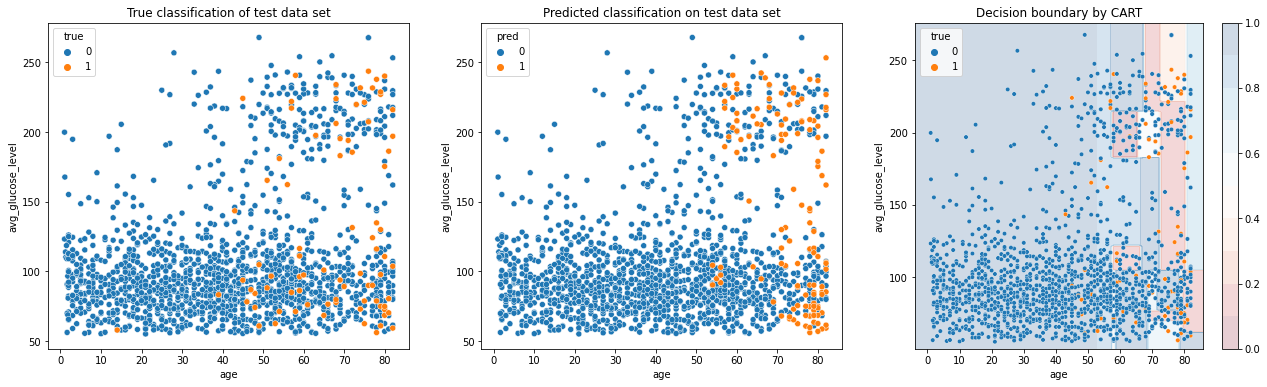

In [13]:
import time
start_train = time.time()

step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(sampling_strategy=0.3, random_state=seed))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed, min_samples_split=37, min_samples_leaf=11, ccp_alpha=0.001))

cart = Pipeline([step_trans,
                  step_smote,
                  step_cart])

# prepare the model
cart.fit(X_train, Y_train)
end_train = time.time()

# estimate on the test dataset
start_pred = time.time()
Y_pred = cart.predict(X_test)
end_pred = time.time()
print("CART training time: %ss" % (end_train - start_train))
print("CART predicting time: %ss" % (end_pred - start_pred))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

data_test = X_test.copy()
data_test['true'] = Y_test
data_test['pred'] = Y_pred
data_test.sort_values('true', inplace=True)

pyplot.figure(figsize=(22, 6))
pyplot.subplot(1, 3, 1)
seaborn.scatterplot(data=data_test, x='age', y='avg_glucose_level', hue='true')
pyplot.title('True classification of test data set')

data_test.sort_values('pred', inplace=True)
pyplot.subplot(1, 3, 2)
seaborn.scatterplot(data=data_test, x='age', y='avg_glucose_level', hue='pred')
pyplot.title('Predicted classification on test data set')


# visualize
model = Pipeline([step_smote,
                  step_cart])
visulize_boundary(model, X_train, Y_train, (1, 3, 3))

pyplot.title('Decision boundary by CART')
pyplot.savefig("./CART_figures/CART_final_prediction.png")
pyplot.show()

[0.21276596 0.14159292 0.25742574 0.25263158 0.25531915 0.24299065
 0.21568627 0.30769231 0.26530612 0.22608696 0.24691358 0.25531915
 0.15189873 0.30088496 0.2826087  0.225      0.20689655 0.2037037
 0.28888889 0.28125    0.13333333 0.23255814 0.17391304 0.24
 0.30379747 0.27419355 0.27272727 0.21428571 0.26168224 0.25
 0.11764706 0.18947368 0.2173913  0.16176471 0.23404255 0.26373626
 0.23636364 0.23622047 0.2173913  0.20338983 0.2        0.20168067
 0.1978022  0.24242424 0.23529412 0.15555556 0.26086957 0.19047619
 0.27522936 0.18367347]
std: 0.045


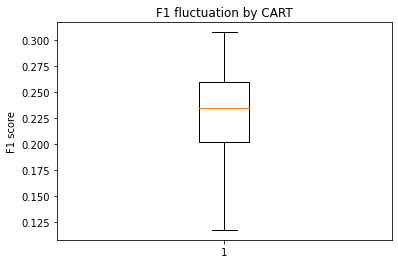

In [16]:
cv_results = cross_val_score(cart, X_train, Y_train, cv=kfold, scoring=scoring)
print(cv_results)
print("std: %.3f" % cv_results.std())
pyplot.boxplot(cv_results)
# pyplot.xlabel()
pyplot.ylabel("F1 score")
pyplot.title("F1 fluctuation by CART")
pyplot.savefig("./CART_figures/CART_stability.png")
pyplot.show()


We expect recall is as high as possible, because we don't want to mis-label any stroke patients as not stroke when we do prediction.

## 6.2 Save model for later use

Save model

In [105]:
dump(cart, open('cart.pkl', 'wb'))

Load saved model

In [63]:
model = load(open('cart.pkl', 'rb'))

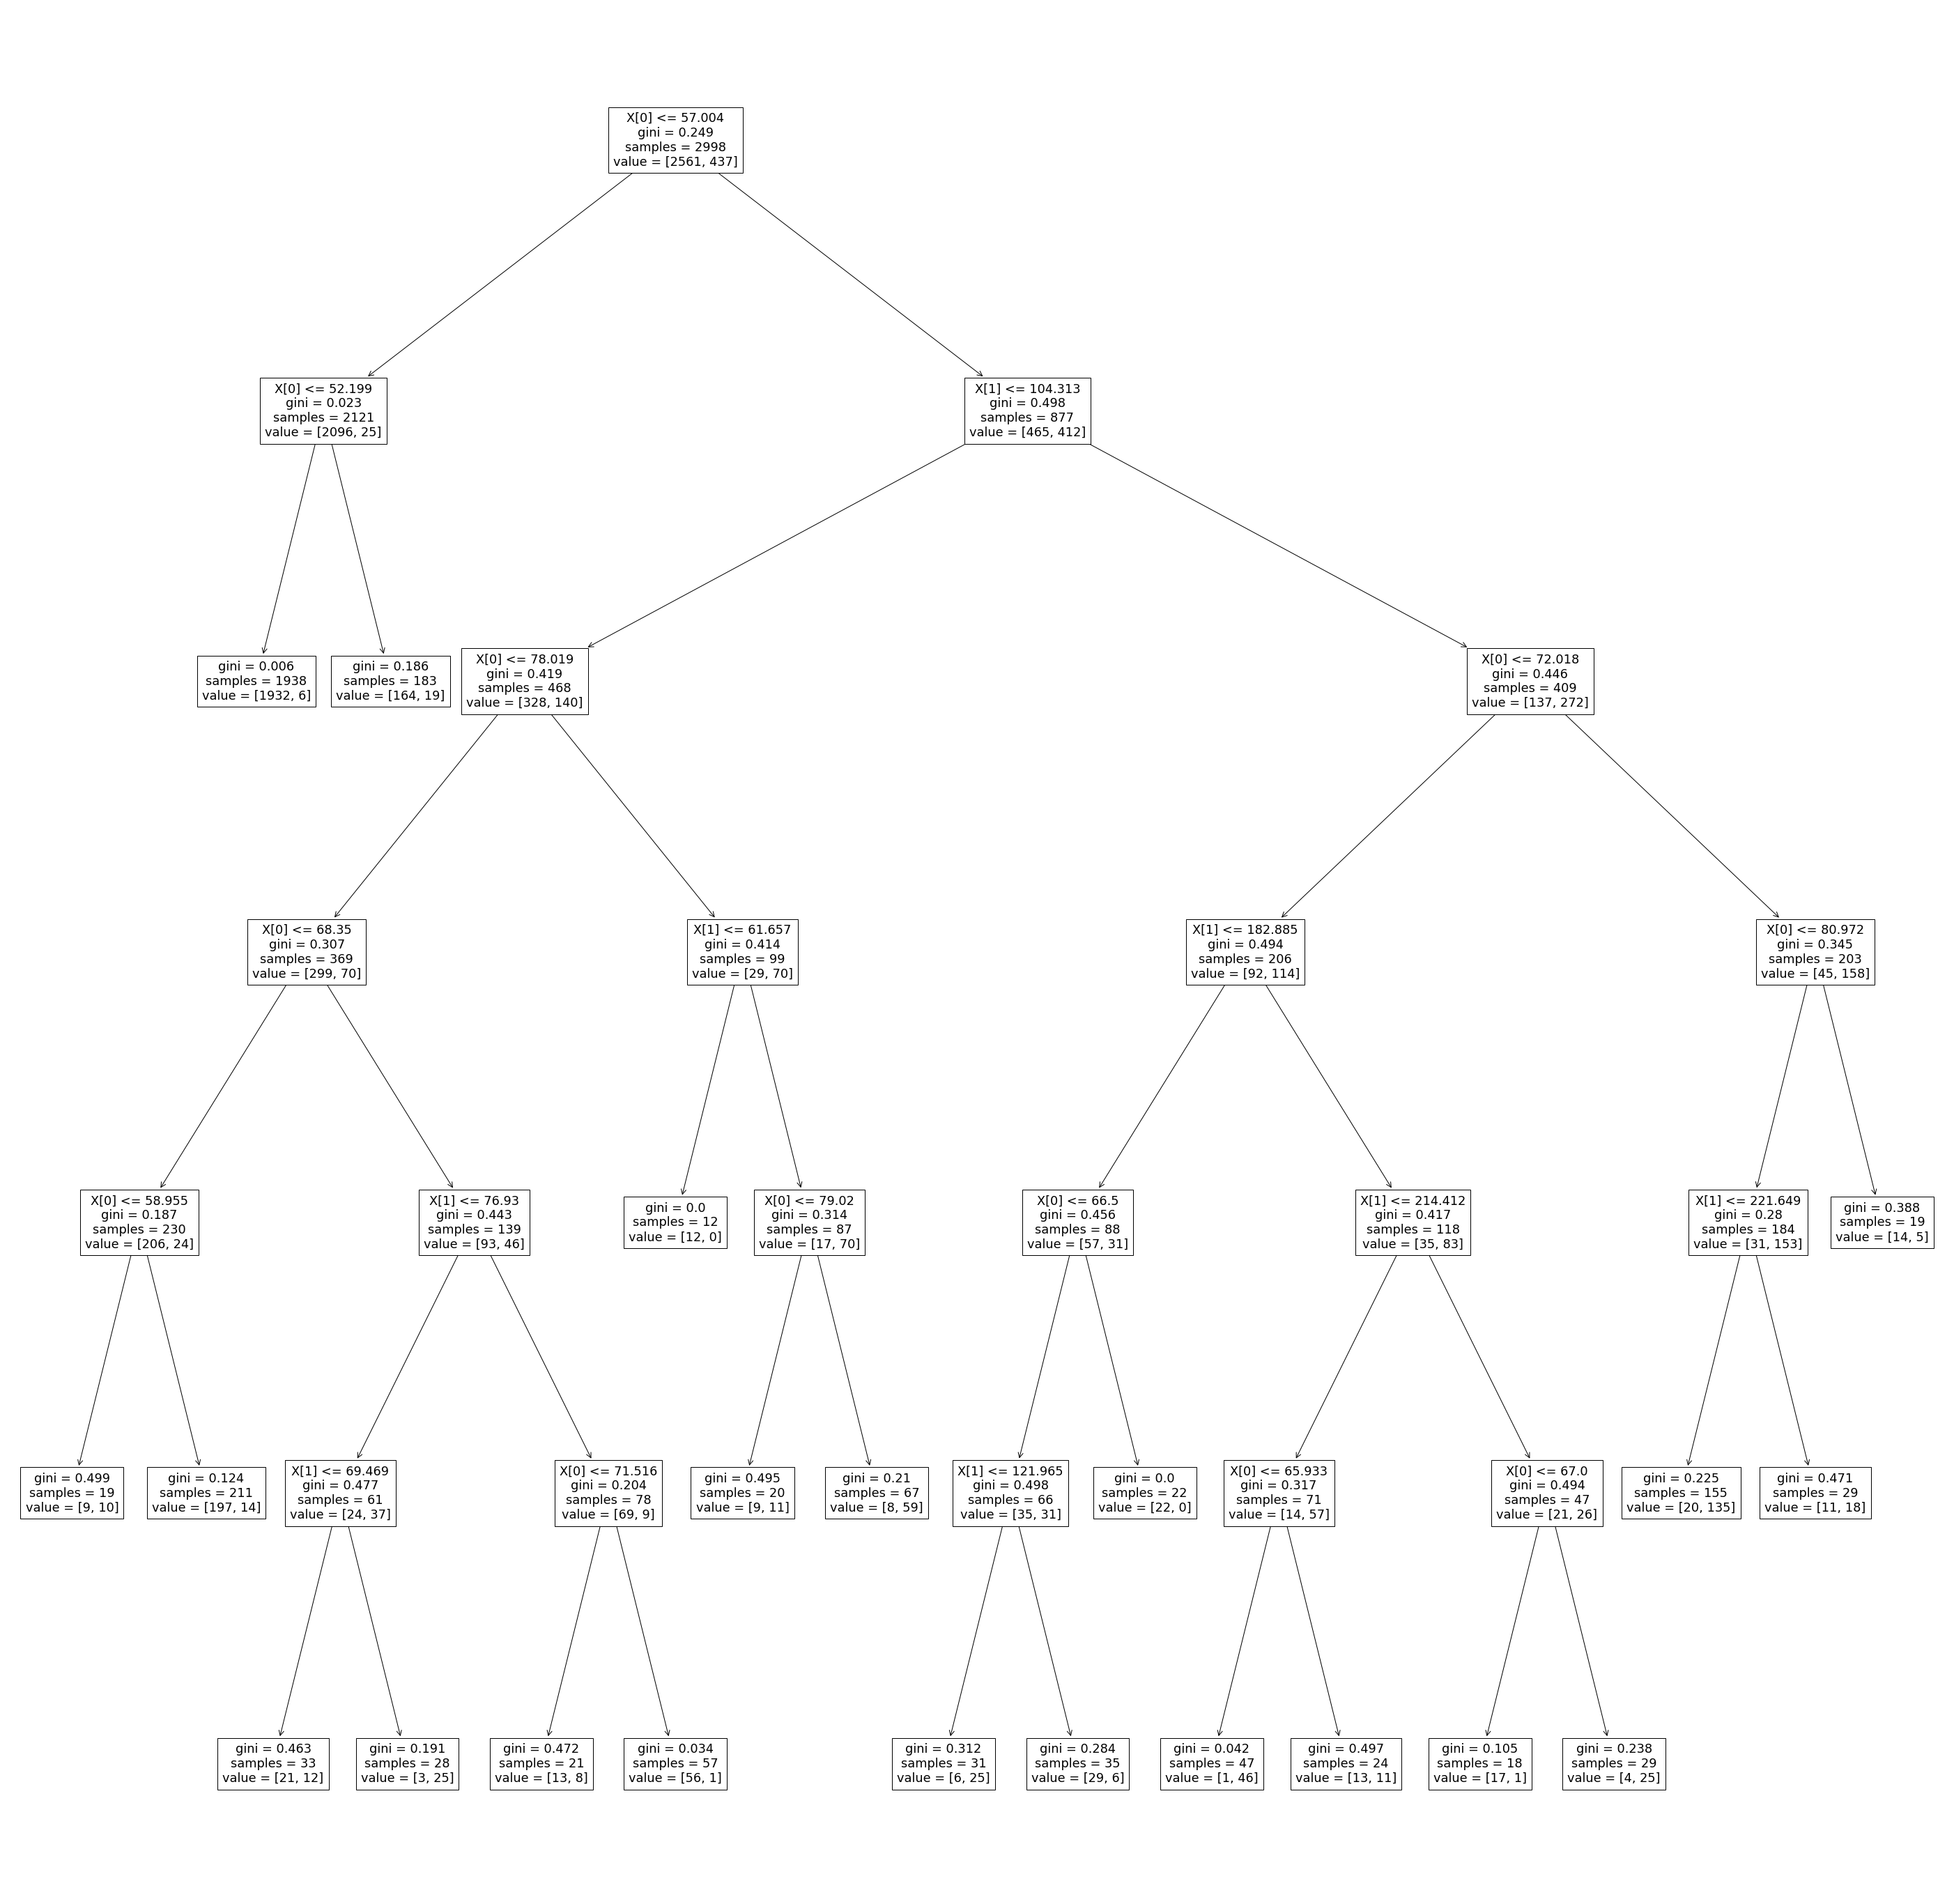

In [106]:
pyplot.figure(figsize=(50, 50))
tree.plot_tree(cart['CART'])
pyplot.savefig('./CART_figures/CART_visualize.png')
pyplot.show()

